In [53]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, Conv1D, GlobalMaxPooling1D, Bidirectional, LSTM
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('english'))

In [58]:
df = pd.read_csv('/home/keyless/Downloads/labeled_data.csv')

In [59]:
df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [38]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 7 columns):
Unnamed: 0            24783 non-null int64
count                 24783 non-null int64
hate_speech           24783 non-null int64
offensive_language    24783 non-null int64
neither               24783 non-null int64
class                 24783 non-null int64
tweet                 24783 non-null object
dtypes: int64(6), object(1)
memory usage: 1.3+ MB


In [39]:
df.hate_speech.value_counts()

0    19790
1     3419
2     1251
3      287
4       21
5        7
6        5
7        3
Name: hate_speech, dtype: int64

In [40]:
df = df.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text
df['tweet'] = df['tweet'].apply(clean_text)

In [41]:
df['tweet'] = df['tweet'].str.replace('\d+', '')

In [42]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each tweet.
MAX_SEQUENCE_LENGTH = 10
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['tweet'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 36007 unique tokens.


In [43]:
X = tokenizer.texts_to_sequences(df['tweet'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)


Shape of data tensor: (24783, 10)


In [44]:
Y = pd.get_dummies(df['class']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (24783, 3)


In [45]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(22304, 10) (22304, 3)
(2479, 10) (2479, 3)


In [46]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(Bidirectional(LSTM(10, return_sequences=True),
                        input_shape=(5, 10)))
model.add(Bidirectional(LSTM(10)))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 10, 100)           5000000   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 10, 20)            8880      
_________________________________________________________________
bidirectional_4 (Bidirection (None, 20)                2480      
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 63        
Total params: 5,011,423
Trainable params: 5,011,423
Non-trainable params: 0
_________________________________________________________________
None


In [47]:
epochs = 5
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Train on 20073 samples, validate on 2231 samples
Epoch 1/5
20073/20073 [==============================] - 23s 1ms/step - loss: 0.4412 - acc: 0.8473 - val_loss: 0.3138 - val_acc: 0.8965
Epoch 2/5
20073/20073 [==============================] - 20s 1ms/step - loss: 0.2728 - acc: 0.9047 - val_loss: 0.2751 - val_acc: 0.9009
Epoch 3/5
20073/20073 [==============================] - 20s 1ms/step - loss: 0.2169 - acc: 0.9253 - val_loss: 0.2808 - val_acc: 0.8969
Epoch 4/5
20073/20073 [==============================] - 22s 1ms/step - loss: 0.1845 - acc: 0.9378 - val_loss: 0.2945 - val_acc: 0.8920
Epoch 5/5
20073/20073 [==============================] - 21s 1ms/step - loss: 0.1588 - acc: 0.9462 - val_loss: 0.3136 - val_acc: 0.8956


In [48]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

2479/2479 [==============================] - 0s 136us/step
Test set
  Loss: 0.380
  Accuracy: 0.873


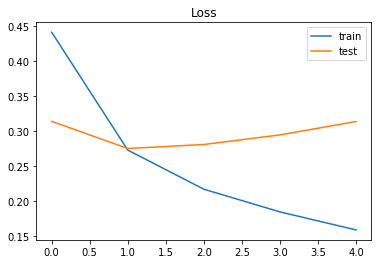

In [49]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();


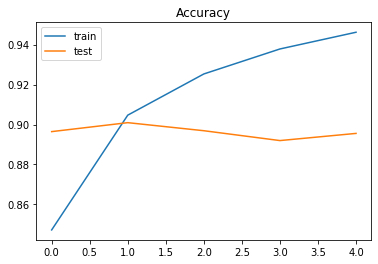

In [50]:
plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show();

In [64]:

new_tweet = ['As a woman you shouldnt complain about cleaning up your house. &amp']
seq = tokenizer.texts_to_sequences(new_tweet)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
labels = ['Hate_speech', 'Offensive_language', 'None']
print(pred,labels[np.argmax(pred)])



[[0.00729112 0.03303415 0.9596747 ]] None
